# Autogluon implementation of Chronos

In [125]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor
from sklearn.model_selection import TimeSeriesSplit
import os

In [141]:
# Import the data
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df.set_index('Date', inplace=True)
    df = pd.DataFrame(df)
    return df

In [142]:
train_df = load_and_prepare_data('../data/Final_data/train_df_no_lags.csv')
test_df = load_and_prepare_data('../data/Final_data/test_df_no_lags.csv')
data = load_and_prepare_data('../data/Final_data/final_data_no_lags.csv')

train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)
data.reset_index(inplace=True)

In [ ]:
data = data[['Date', 'Day_ahead_price (€/MWh)']]
# create unique_id column with equal to 1
data['unique_id'] = 1

# Ensure the DataFrame has the correct column names
data = data.rename(columns={'unique_id': 'item_id',
                   'Date': 'timestamp', 'Day_ahead_price (€/MWh)': 'target'})

# Reset index and sort the DataFrame by 'item_id' and 'timestamp' to ensure proper ordering
data = data.reset_index(drop=True).sort_values(['item_id', 'timestamp'])

# Put item_id first
data = data[['item_id', 'timestamp', 'target']]

data_ts = TimeSeriesDataFrame.from_data_frame(
    data, id_column='item_id', timestamp_column='timestamp')

In [ ]:
# Define prediction length
prediction_length = len(test_df)

# Split the data in train and test set
train_data, test_data = data_ts.train_test_split(prediction_length)

# Initialize and fit the predictor
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "mini",
            "batch_size": 16,
            "device": "cpu",
        }
    },
    skip_model_selection=True,
    verbosity=0,
)

In [130]:
train_data

target
item_id timestamp         
1       2012-01-08   26.83
        2012-01-09   47.91
        2012-01-10   45.77
        2012-01-11   47.83
        2012-01-12   43.10
...                    ...
        2022-06-26  201.67
        2022-06-27  316.65
        2022-06-28  331.52
        2022-06-29  315.54
        2022-06-30  325.48

[3827 rows x 1 columns]

In [131]:
test_data

target
item_id timestamp         
1       2012-01-08   26.83
        2012-01-09   47.91
        2012-01-10   45.77
        2012-01-11   47.83
        2012-01-12   43.10
...                    ...
        2024-07-24   66.61
        2024-07-25   78.34
        2024-07-26   93.04
        2024-07-27   80.74
        2024-07-28   43.96

[4586 rows x 1 columns]

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20241111_223957'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:05:14 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       2.69 GB / 16.00 GB (16.8%)
Disk Space Avail:   56.97 GB / 460.43 GB (12.4%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'batch_size': 16,
                                 'device': 'cpu',
                                 'model_path': 'mini'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 759,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False

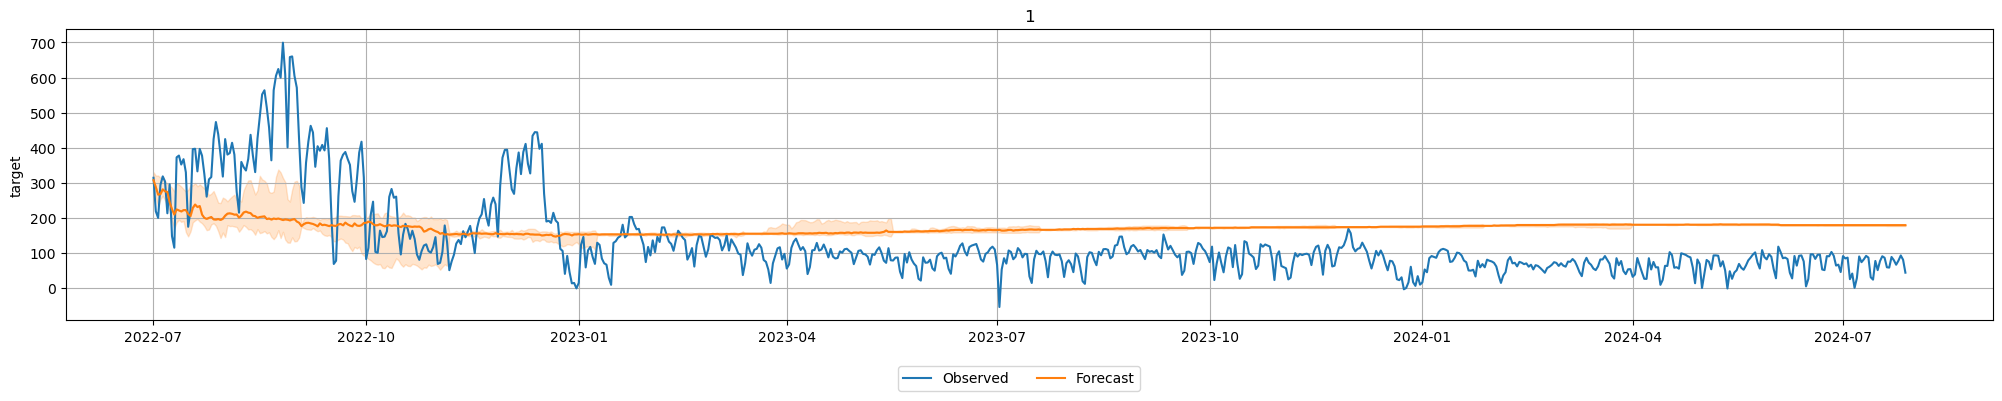

In [ ]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

# Load and prepare the data


def load_and_prepare_data(file_path):
    df = pd.read_csv(file_path)
    df.sort_values('Date', inplace=True)
    df = df.rename(columns={'Date': 'timestamp',
                   'Day_ahead_price (€/MWh)': 'target'})
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['item_id'] = 1  # Create a constant item_id column for a single series
    return df[['item_id', 'timestamp', 'target']]


# Load data
train_df = load_and_prepare_data('../data/Final_data/train_df_no_lags.csv')
test_df = load_and_prepare_data('../data/Final_data/test_df_no_lags.csv')
full_data = pd.concat([train_df, test_df])

# Convert scaled data to TimeSeriesDataFrame
data_ts = TimeSeriesDataFrame.from_data_frame(
    full_data, id_column='item_id', timestamp_column='timestamp')

# Define prediction length
prediction_length = len(test_df)

# Split the scaled data into train and test sets
train_data, test_data = data_ts.train_test_split(prediction_length)

# Initialize and fit the predictor
predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data,
    hyperparameters={
        "Chronos": {
            "model_path": "mini",
            "batch_size": 16,
            "device": "cpu",
        }
    },
    verbosity=2,
)

# Generate predictions on the scaled test data
predictions = predictor.predict(train_data)

# Plot the predictions vs. actual values#
predictor.plot(
    data=data_ts,
    predictions=predictions,
    item_ids=[1],
    max_history_length=len(test_df),
)

# Standard Autogluon apporach 

In [ ]:
data = TimeSeriesDataFrame(
    "https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_tiny/train.csv"
)
data.head()

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0

In [117]:
prediction_length = 24
train_data, test_data = data.train_test_split(prediction_length)

predictor = TimeSeriesPredictor(prediction_length=prediction_length).fit(
    train_data, presets="chronos_tiny",
)

Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20241111_220456'


=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.13
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:05:14 PDT 2024; root:xnu-11215.41.3~2/RELEASE_ARM64_T8103
CPU Count:          8
GPU Count:          0
Memory Avail:       3.09 GB / 16.00 GB (19.3%)
Disk Space Avail:   57.02 GB / 460.43 GB (12.4%)
Setting presets to: chronos_tiny

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'hyperparameters': {'Chronos': {'model_path': 'tiny'}},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 24,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': True,
 'target': 'target',
 'verbosity': 2}

Inferred time series frequency: 'h'
Provided train_data has 13520 rows, 20 time series. Median time series length is 676 (min=67

In [118]:
train_data

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0
...                             ...
H20     1750-01-28 23:00:00  8027.0
        1750-01-29 00:00:00  7753.0
        1750-01-29 01:00:00  7583.0
        1750-01-29 02:00:00  7276.0
        1750-01-29 03:00:00  6705.0

[13520 rows x 1 columns]

In [119]:
test_data

target
item_id timestamp                  
H1      1750-01-01 00:00:00   605.0
        1750-01-01 01:00:00   586.0
        1750-01-01 02:00:00   586.0
        1750-01-01 03:00:00   559.0
        1750-01-01 04:00:00   511.0
...                             ...
H20     1750-01-29 23:00:00  8182.0
        1750-01-30 00:00:00  7856.0
        1750-01-30 01:00:00  7687.0
        1750-01-30 02:00:00  7374.0
        1750-01-30 03:00:00  6817.0

[14000 rows x 1 columns]

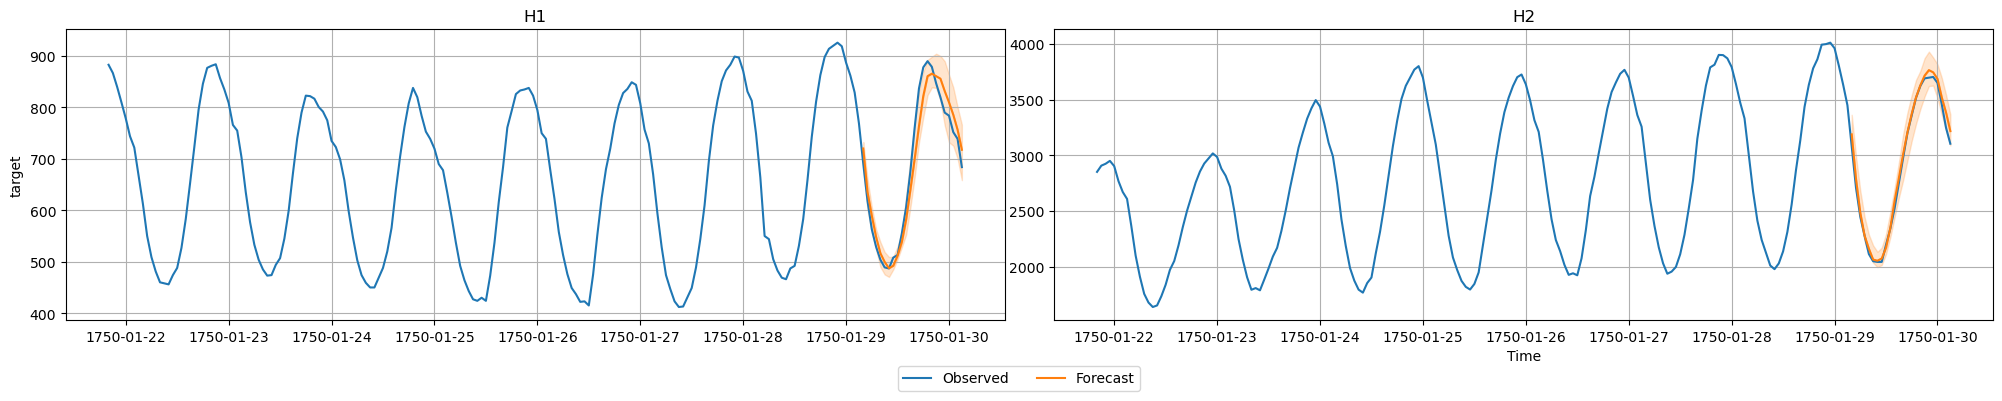

In [ ]:
predictions = predictor.predict(train_data)
predictor.plot(
    data=data,
    predictions=predictions,
    item_ids=["H1", "H2"],
    max_history_length=200,
)

In [ ]:
# Convert TimeSeriesDataFrames to pandas DataFrames by resetting the index
train_df = train_data.reset_index()
test_df = test_data.reset_index()

# Extract unique timestamps
train_timestamps = train_df['timestamp'].unique()
test_timestamps = test_df['timestamp'].unique()

# Check for overlap
overlap = pd.Series(train_timestamps).isin(test_timestamps).any()

if overlap:
    print("train_data and test_data have overlapping timestamps.")
    # Find the exact overlapping timestamps
    overlapping_timestamps = pd.Series(train_timestamps)[
        pd.Series(train_timestamps).isin(test_timestamps)]
    print("Overlapping timestamps:")
    print(overlapping_timestamps)
else:
    print("train_data and test_data do not have overlapping timestamps.")

train_data and test_data have overlapping timestamps.
Overlapping timestamps:
0     1750-01-01 00:00:00
1     1750-01-01 01:00:00
2     1750-01-01 02:00:00
3     1750-01-01 03:00:00
4     1750-01-01 04:00:00
              ...        
671   1750-01-28 23:00:00
672   1750-01-29 00:00:00
673   1750-01-29 01:00:00
674   1750-01-29 02:00:00
675   1750-01-29 03:00:00
Length: 676, dtype: datetime64[ns]
